In [1]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster, Mode
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.1, llvm 10.0.0, commit cc2dd342, linux, python 3.9.7
[TaiGLSL] version 0.0.11


In [2]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [3]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate
MODE = Mode.WYSIWYP

out_dir = Path('/run/media/dome/Cluster/STDepth_data_multi')
ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
# ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [4]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': 3,
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4837)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


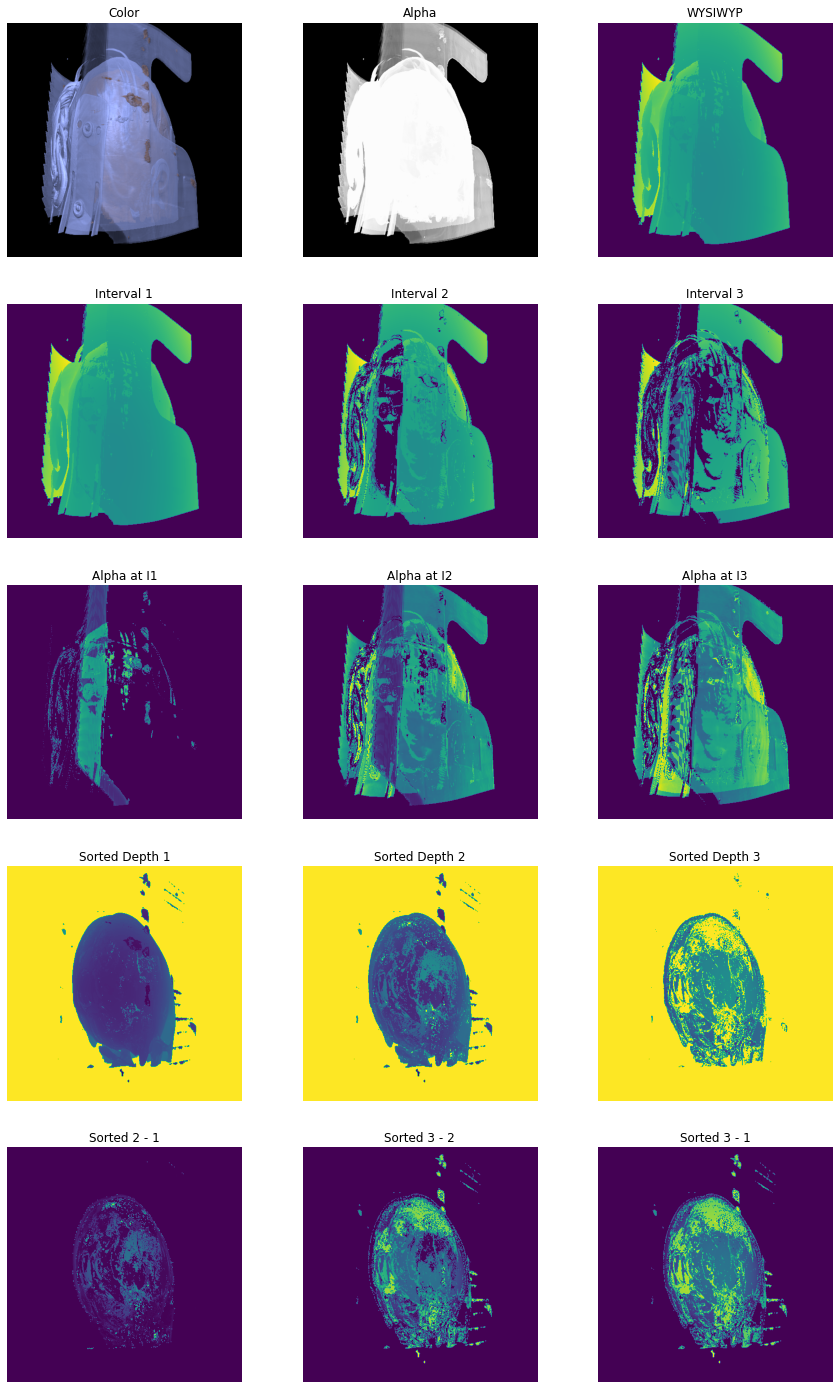

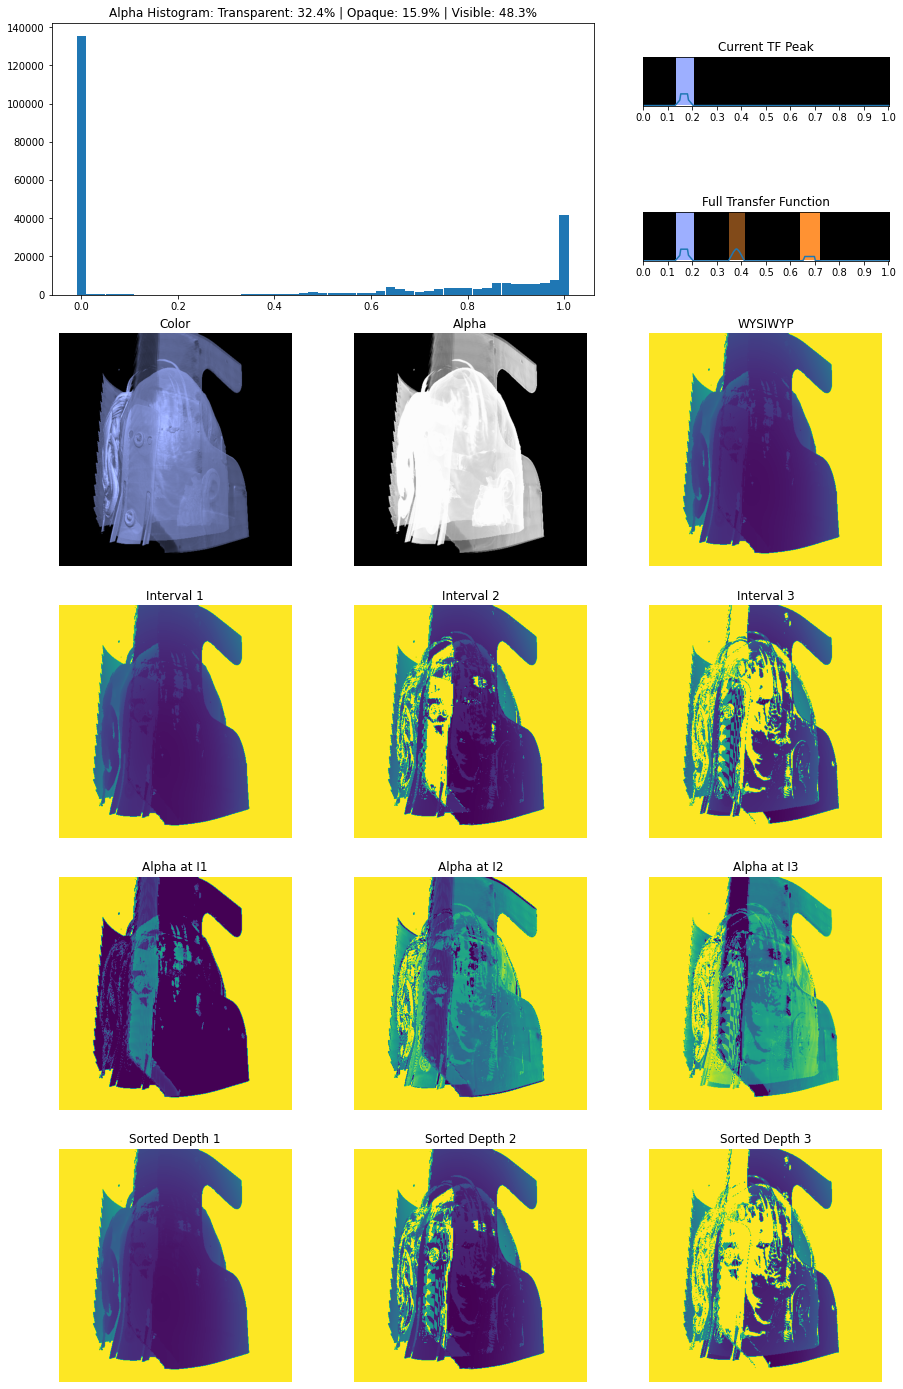

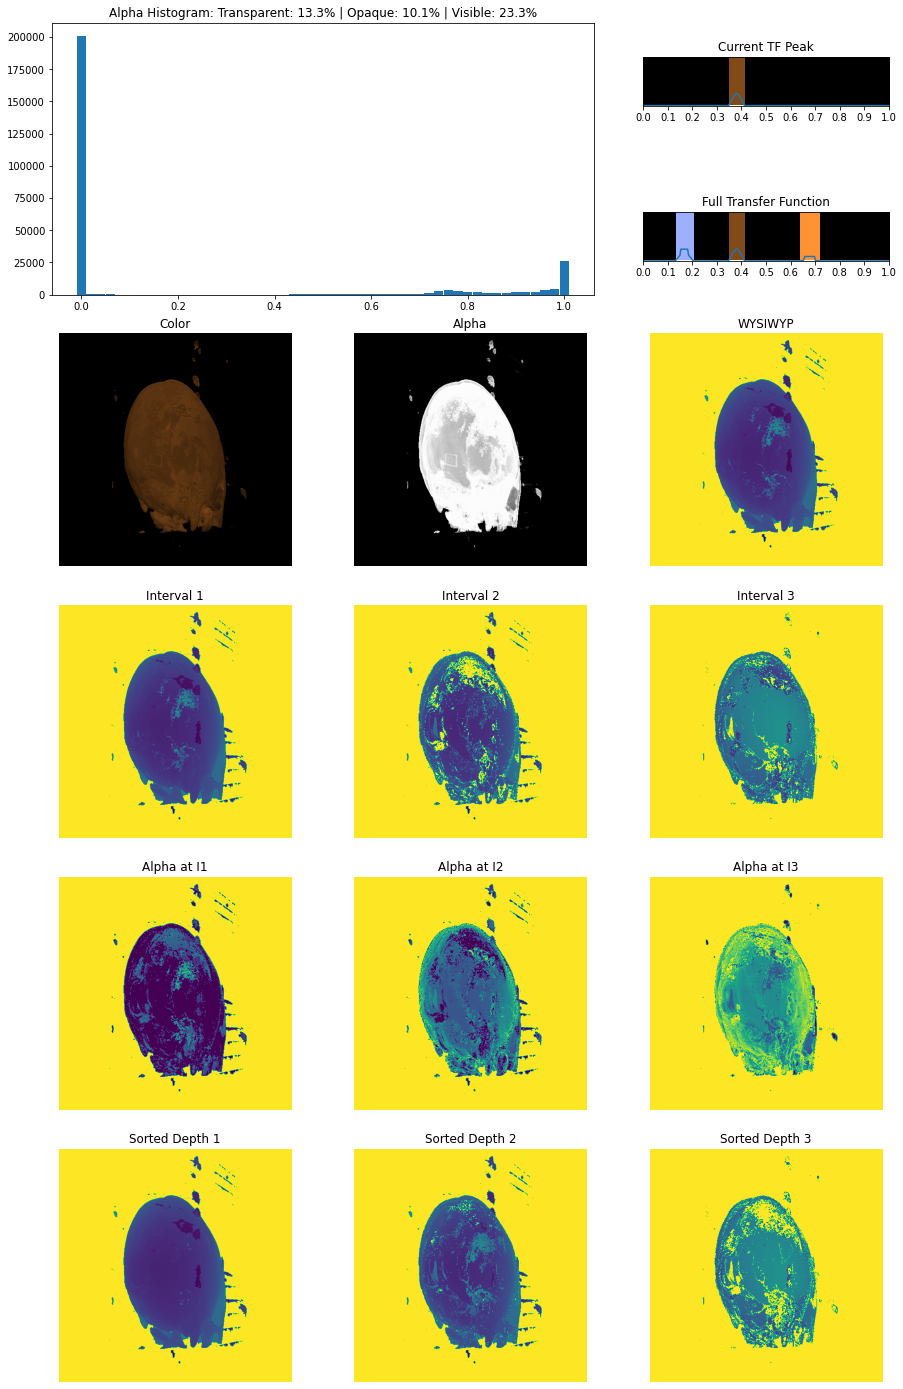

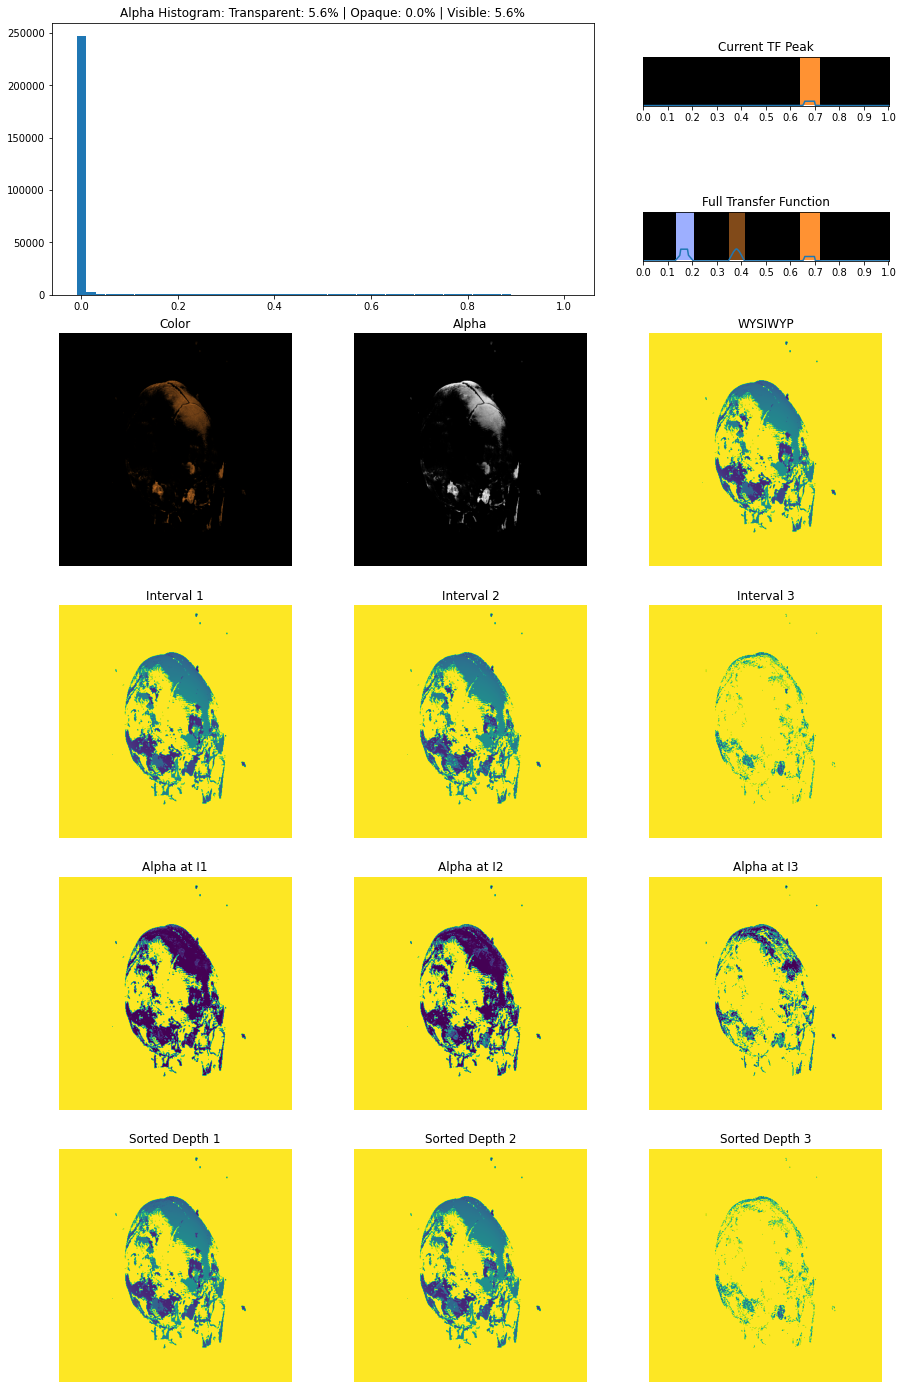

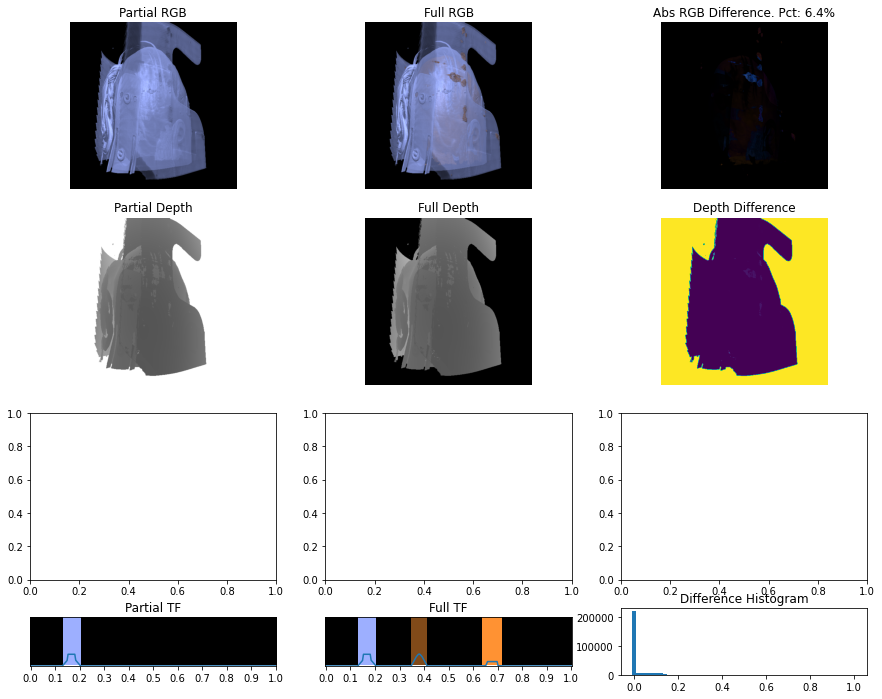

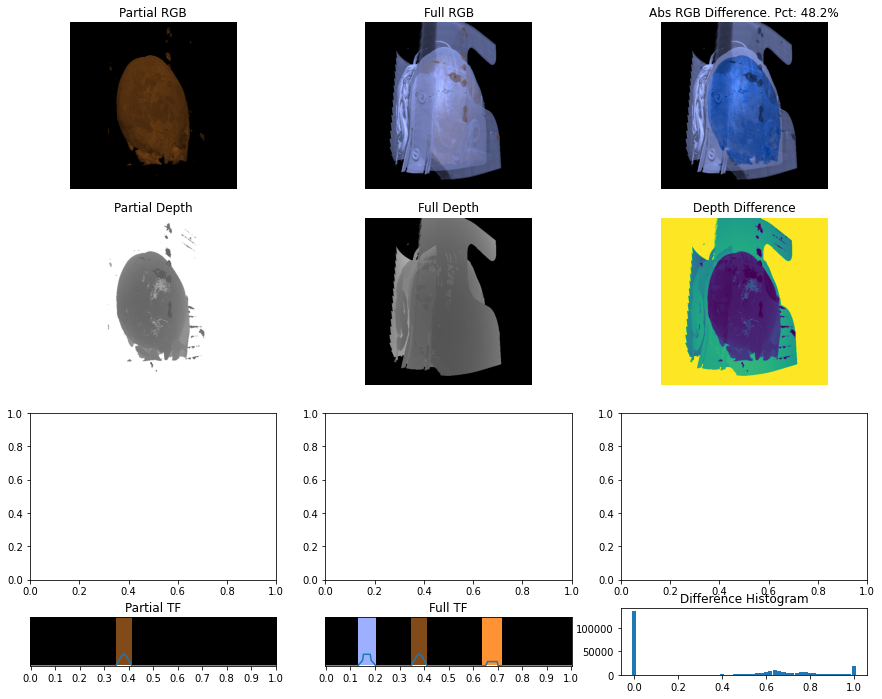

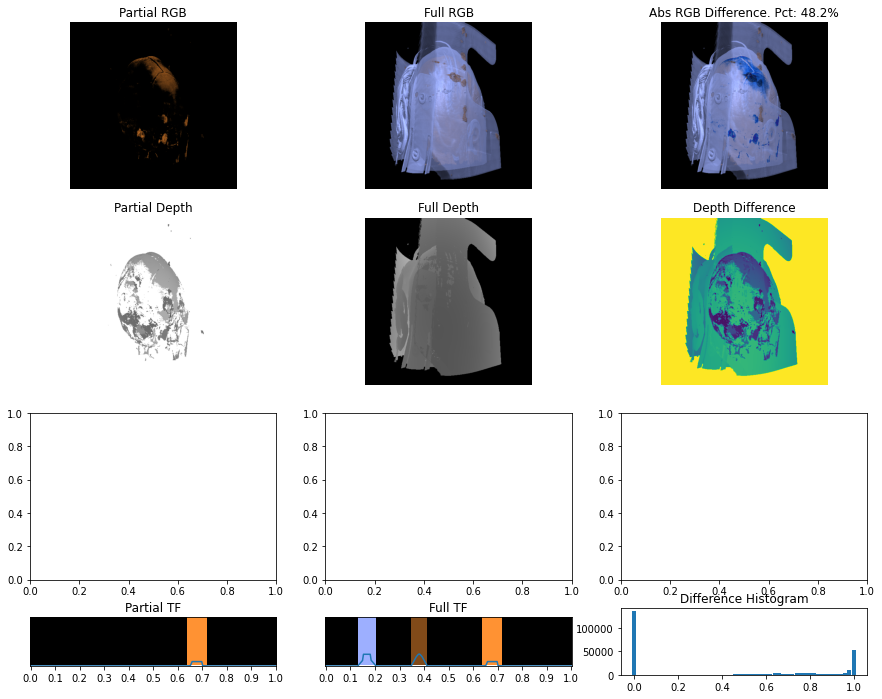

In [19]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
#rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)
print((rgbad_full[3] > 0.0).float().mean())

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    

Percentage 0.02 < Alpha < 0.9:  17.7%
Percentage        Alpha > 0.98: 5.5%
Percentage visible (>=0.02):    23.2%


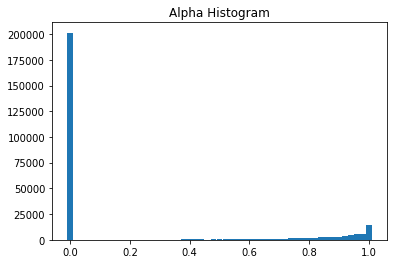

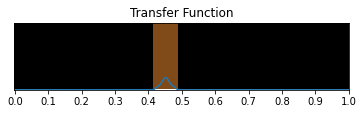

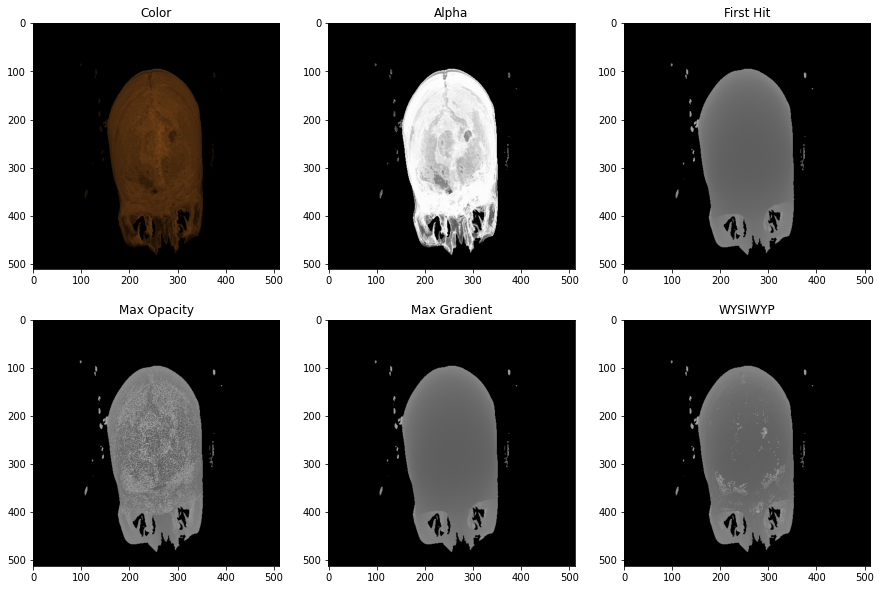

In [11]:
lf = in_circles(4.7)
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
x = torch.linspace(0.0, 1.0, BINS)
hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0).cpu()
print(f'Percentage 0.02 < Alpha < 0.9:  {hst[1:-1].sum()/rgbad[3].numel():.1%}')
print(f'Percentage        Alpha > 0.98: {hst[-1]/rgbad[3].numel():.1%}')
print(f'Percentage visible (>=0.02):    {1.0 - hst[0]/rgbad[3].numel():.1%}')
plt.bar(x, hst, width=1/BINS)
plt.title('Alpha Histogram')
plt.show()
plot_tf(tf, title='Transfer Function')
show_im(rgbad)

In [ ]:
raycaster = None
skips = 0
visibilities = []
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, mode=Mode.WYSIWYP,
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1:
                skips += 1
                print(f'Skipping another useless render ({skips})')
                continue
            elif vis < 0.2:
                skips += 1
                print(f'Skipping another too transparent render ({skips})')
                continue
            else:
                visibilities.append(vis.cpu().float())
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': rgbad[:4].cpu().half(),
                    'wysiwyp1': rgbad[[4]].cpu().half(),
                    'wysiwyp2': rgbad[[5]].cpu().half(),
                    'wysiwyp3': rgbad[[6]].cpu().half(),
                    'alpha1': rgbad[[7]].cpu().half(),
                    'alpha2': rgbad[[8]].cpu().half(),
                    'alpha3': rgbad[[9]].cpu().half(),
                    'visibility': vis.cpu().float()
                }, out_dir/f'{nam}_{i}.pt')
                break
print(f'Average visibility in the dataset: {torch.stack(visibilitieslities).mean():.1%}')

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:04<19:14,  4.58s/it]

Skipping another useless render (1)
Skipping another too transparent render (2)
Skipping another too transparent render (3)



  1%|          | 2/253 [00:07<14:56,  3.57s/it]

Skipping another too transparent render (4)
Skipping another useless render (5)
Skipping another too transparent render (6)
Skipping another too transparent render (7)
Skipping another too transparent render (8)
Skipping another too transparent render (9)



  1%|          | 3/253 [00:11<16:11,  3.89s/it]

Skipping another too transparent render (10)



  2%|▏         | 4/253 [00:13<11:58,  2.89s/it]

Skipping another too transparent render (11)
Skipping another too transparent render (12)
Skipping another too transparent render (13)
Skipping another too transparent render (14)
Skipping another useless render (15)
Skipping another too transparent render (16)



  2%|▏         | 5/253 [00:17<14:03,  3.40s/it]

Skipping another too transparent render (17)



  2%|▏         | 6/253 [00:18<10:50,  2.64s/it]

Skipping another too transparent render (18)



  3%|▎         | 7/253 [00:19<08:56,  2.18s/it]

Skipping another too transparent render (19)



  4%|▎         | 9/253 [00:21<06:15,  1.54s/it]

Skipping another too transparent render (20)
Skipping another too transparent render (21)



  4%|▍         | 10/253 [00:24<07:12,  1.78s/it]

Skipping another useless render (22)
Skipping another too transparent render (23)



  4%|▍         | 11/253 [00:26<07:22,  1.83s/it]

Skipping another too transparent render (24)



  5%|▍         | 12/253 [00:27<06:38,  1.65s/it]

Skipping another too transparent render (25)
Skipping another too transparent render (26)
Skipping another too transparent render (27)
Skipping another too transparent render (28)
Skipping another too transparent render (29)
Skipping another too transparent render (30)
Skipping another too transparent render (31)
Skipping another too transparent render (32)



  6%|▌         | 14/253 [00:33<08:54,  2.24s/it]

Skipping another too transparent render (33)



  6%|▌         | 15/253 [00:35<08:03,  2.03s/it]

Skipping another too transparent render (34)
Skipping another too transparent render (35)



  6%|▋         | 16/253 [00:37<08:09,  2.06s/it]

Skipping another too transparent render (36)
Skipping another too transparent render (37)
Skipping another too transparent render (38)
Skipping another too transparent render (39)



  7%|▋         | 18/253 [00:41<07:28,  1.91s/it]

Skipping another too transparent render (40)



  8%|▊         | 19/253 [00:42<06:42,  1.72s/it]

Skipping another too transparent render (41)
Skipping another too transparent render (42)
Skipping another too transparent render (43)
Skipping another too transparent render (44)
Skipping another too transparent render (45)



  8%|▊         | 20/253 [00:46<09:18,  2.40s/it]

Skipping another too transparent render (46)
Skipping another too transparent render (47)
Skipping another useless render (48)



  9%|▉         | 23/253 [00:50<06:08,  1.60s/it]

Skipping another too transparent render (49)
Skipping another useless render (50)
Skipping another too transparent render (51)
Skipping another too transparent render (52)
Skipping another too transparent render (53)
Skipping another too transparent render (54)



  9%|▉         | 24/253 [00:56<10:22,  2.72s/it]

Skipping another too transparent render (55)



 10%|▉         | 25/253 [00:57<08:55,  2.35s/it]

Skipping another too transparent render (56)
Skipping another useless render (57)



 11%|█         | 27/253 [01:00<06:49,  1.81s/it]

Skipping another too transparent render (58)
Skipping another too transparent render (59)
Skipping another too transparent render (60)



 12%|█▏        | 30/253 [01:04<05:08,  1.38s/it]

Skipping another too transparent render (61)



 12%|█▏        | 31/253 [01:06<05:16,  1.43s/it]

Skipping another too transparent render (62)



 13%|█▎        | 33/253 [01:08<04:35,  1.25s/it]

Skipping another too transparent render (63)
Skipping another too transparent render (64)
Skipping another too transparent render (65)
Skipping another useless render (66)
Skipping another too transparent render (67)



 13%|█▎        | 34/253 [01:12<07:40,  2.10s/it]

Skipping another too transparent render (68)
Skipping another useless render (69)
Skipping another useless render (70)
Skipping another too transparent render (71)



 15%|█▍        | 37/253 [01:17<05:43,  1.59s/it]

Skipping another too transparent render (72)
Skipping another too transparent render (73)
Skipping another too transparent render (74)
Skipping another too transparent render (75)
Skipping another too transparent render (76)
Skipping another too transparent render (77)
Skipping another too transparent render (78)
Skipping another too transparent render (79)
Skipping another too transparent render (80)
Skipping another too transparent render (81)
Skipping another too transparent render (82)
Skipping another too transparent render (83)



 15%|█▌        | 38/253 [01:25<12:40,  3.54s/it]

Skipping another too transparent render (84)
Skipping another too transparent render (85)
Skipping another useless render (86)
Skipping another too transparent render (87)
Skipping another too transparent render (88)
Skipping another too transparent render (89)
Skipping another too transparent render (90)



 15%|█▌        | 39/253 [01:30<14:53,  4.17s/it]

Skipping another too transparent render (91)



 16%|█▌        | 40/253 [01:32<11:45,  3.31s/it]

Skipping another too transparent render (92)
Skipping another too transparent render (93)



 16%|█▌        | 41/253 [01:34<10:05,  2.86s/it]

Skipping another too transparent render (94)
Skipping another too transparent render (95)
Skipping another too transparent render (96)
Skipping another useless render (97)
Skipping another too transparent render (98)



 17%|█▋        | 42/253 [01:38<11:28,  3.26s/it]

Skipping another too transparent render (99)
Skipping another too transparent render (100)
Skipping another too transparent render (101)



 17%|█▋        | 43/253 [01:41<10:57,  3.13s/it]

Skipping another too transparent render (102)
Skipping another too transparent render (103)



 18%|█▊        | 46/253 [01:44<06:00,  1.74s/it]

Skipping another too transparent render (104)
Skipping another too transparent render (105)



 19%|█▊        | 47/253 [01:46<05:49,  1.70s/it]

Skipping another too transparent render (106)



 19%|█▉        | 48/253 [01:47<05:30,  1.61s/it]

Skipping another too transparent render (107)
Skipping another too transparent render (108)
Skipping another too transparent render (109)
Skipping another too transparent render (110)
Skipping another too transparent render (111)



 19%|█▉        | 49/253 [01:51<07:55,  2.33s/it]

Skipping another too transparent render (112)



 20%|█▉        | 50/253 [01:52<06:35,  1.95s/it]

Skipping another too transparent render (113)



 20%|██        | 51/253 [01:53<05:58,  1.77s/it]

Skipping another too transparent render (114)



 21%|██        | 53/253 [01:56<04:48,  1.44s/it]

Skipping another too transparent render (115)
Skipping another too transparent render (116)
Skipping another too transparent render (117)
Skipping another too transparent render (118)
Skipping another too transparent render (119)
Skipping another too transparent render (120)
Skipping another too transparent render (121)



 21%|██▏       | 54/253 [02:02<09:06,  2.75s/it]

Skipping another too transparent render (122)



 22%|██▏       | 55/253 [02:03<07:42,  2.34s/it]

Skipping another too transparent render (123)
Skipping another useless render (124)
Skipping another useless render (125)
Skipping another too transparent render (126)



 23%|██▎       | 57/253 [02:08<07:02,  2.16s/it]

Skipping another too transparent render (127)
Skipping another too transparent render (128)
Skipping another too transparent render (129)
Skipping another too transparent render (130)



 23%|██▎       | 58/253 [02:11<07:58,  2.45s/it]

Skipping another useless render (131)
Skipping another too transparent render (132)



 23%|██▎       | 59/253 [02:13<07:40,  2.38s/it]

Skipping another too transparent render (133)
Skipping another too transparent render (134)
Skipping another too transparent render (135)
Skipping another useless render (136)
Skipping another too transparent render (137)
Skipping another too transparent render (138)
Skipping another too transparent render (139)
Skipping another too transparent render (140)
Skipping another too transparent render (141)



 24%|██▎       | 60/253 [02:19<11:27,  3.56s/it]

Skipping another too transparent render (142)
Skipping another useless render (143)
Skipping another too transparent render (144)
Skipping another too transparent render (145)
Skipping another too transparent render (146)
Skipping another too transparent render (147)



 24%|██▍       | 61/253 [02:24<12:23,  3.87s/it]

Skipping another too transparent render (148)



 25%|██▍       | 62/253 [02:25<09:49,  3.09s/it]

Skipping another too transparent render (149)
Skipping another too transparent render (150)
Skipping another too transparent render (151)



 25%|██▌       | 64/253 [02:29<07:33,  2.40s/it]

Skipping another too transparent render (152)
Skipping another too transparent render (153)
Skipping another too transparent render (154)
Skipping another too transparent render (155)



 26%|██▌       | 65/253 [02:32<08:29,  2.71s/it]

Skipping another too transparent render (156)



 26%|██▌       | 66/253 [02:34<07:05,  2.27s/it]

Skipping another too transparent render (157)
Skipping another useless render (158)
Skipping another useless render (159)
Skipping another too transparent render (160)
Skipping another too transparent render (161)
Skipping another too transparent render (162)



 26%|██▋       | 67/253 [02:38<08:57,  2.89s/it]

Skipping another too transparent render (163)



 27%|██▋       | 68/253 [02:39<07:29,  2.43s/it]

Skipping another too transparent render (164)
Skipping another too transparent render (165)
Skipping another useless render (166)
Skipping another too transparent render (167)
Skipping another too transparent render (168)



 27%|██▋       | 69/253 [02:43<08:46,  2.86s/it]

Skipping another too transparent render (169)
Skipping another too transparent render (170)
Skipping another too transparent render (171)
Skipping another too transparent render (172)
Skipping another too transparent render (173)
Skipping another too transparent render (174)
Skipping another useless render (175)
Skipping another too transparent render (176)
Skipping another too transparent render (177)
Skipping another too transparent render (178)
Skipping another too transparent render (179)
Skipping another too transparent render (180)
Skipping another too transparent render (181)
Skipping another too transparent render (182)



 28%|██▊       | 71/253 [02:53<10:40,  3.52s/it]

Skipping another too transparent render (183)
Skipping another too transparent render (184)
Skipping another too transparent render (185)



 28%|██▊       | 72/253 [02:55<09:32,  3.16s/it]

Skipping another too transparent render (186)



 29%|██▉       | 73/253 [02:57<08:03,  2.68s/it]

Skipping another too transparent render (187)
Skipping another too transparent render (188)



 29%|██▉       | 74/253 [02:59<07:13,  2.42s/it]

Skipping another useless render (189)
Skipping another too transparent render (190)



 30%|██▉       | 75/253 [03:01<06:58,  2.35s/it]

Skipping another too transparent render (191)
Skipping another too transparent render (192)
Skipping another too transparent render (193)
Skipping another too transparent render (194)
Skipping another too transparent render (195)



 30%|███       | 77/253 [03:06<06:34,  2.24s/it]

Skipping another too transparent render (196)



 31%|███       | 79/253 [03:07<04:30,  1.56s/it]

Skipping another too transparent render (197)
Skipping another too transparent render (198)



 32%|███▏      | 82/253 [03:12<03:47,  1.33s/it]

Skipping another too transparent render (199)
Skipping another useless render (200)



 33%|███▎      | 83/253 [03:14<04:38,  1.64s/it]

Skipping another too transparent render (201)
Skipping another too transparent render (202)
Skipping another too transparent render (203)
Skipping another too transparent render (204)
Skipping another too transparent render (205)
Skipping another too transparent render (206)
Skipping another too transparent render (207)
Skipping another too transparent render (208)
Skipping another too transparent render (209)
Skipping another too transparent render (210)
Skipping another too transparent render (211)
Skipping another too transparent render (212)
Skipping another too transparent render (213)
Skipping another too transparent render (214)
Skipping another too transparent render (215)
Skipping another too transparent render (216)
Skipping another too transparent render (217)
Skipping another too transparent render (218)



 33%|███▎      | 84/253 [03:26<13:19,  4.73s/it]

Skipping another too transparent render (219)



 34%|███▍      | 86/253 [03:28<07:48,  2.81s/it]

Skipping another too transparent render (220)
Skipping another too transparent render (221)
Skipping another too transparent render (222)



 34%|███▍      | 87/253 [03:30<07:35,  2.75s/it]

Skipping another too transparent render (223)



 35%|███▍      | 88/253 [03:32<06:23,  2.33s/it]

Skipping another too transparent render (224)
Skipping another useless render (225)
Skipping another too transparent render (226)



 35%|███▌      | 89/253 [03:35<06:46,  2.48s/it]

Skipping another too transparent render (227)
Skipping another too transparent render (228)
Skipping another too transparent render (229)



 36%|███▌      | 90/253 [03:37<06:56,  2.56s/it]

Skipping another too transparent render (230)
Skipping another too transparent render (231)



 36%|███▋      | 92/253 [03:40<05:06,  1.90s/it]

Skipping another too transparent render (232)
Skipping another too transparent render (233)



 37%|███▋      | 94/253 [03:43<04:07,  1.55s/it]

Skipping another too transparent render (234)
Skipping another too transparent render (235)
Skipping another too transparent render (236)
Skipping another too transparent render (237)
Skipping another too transparent render (238)
Skipping another too transparent render (239)
Skipping another too transparent render (240)
Skipping another too transparent render (241)
Skipping another too transparent render (242)
Skipping another too transparent render (243)



 38%|███▊      | 96/253 [03:49<05:43,  2.19s/it]

Skipping another too transparent render (244)
Skipping another too transparent render (245)
Skipping another useless render (246)



 38%|███▊      | 97/253 [03:52<06:07,  2.36s/it]

Skipping another too transparent render (247)
Skipping another too transparent render (248)
Skipping another too transparent render (249)
Skipping another too transparent render (250)



 39%|███▊      | 98/253 [03:56<07:00,  2.71s/it]

Skipping another too transparent render (251)



 40%|███▉      | 100/253 [03:58<04:35,  1.80s/it]

Skipping another too transparent render (252)
Skipping another too transparent render (253)



 40%|███▉      | 101/253 [03:59<04:37,  1.83s/it]

Skipping another too transparent render (254)
Skipping another too transparent render (255)



 40%|████      | 102/253 [04:01<04:35,  1.83s/it]

Skipping another too transparent render (256)
Skipping another too transparent render (257)
Skipping another too transparent render (258)
Skipping another too transparent render (259)
Skipping another too transparent render (260)
Skipping another too transparent render (261)
Skipping another too transparent render (262)
Skipping another useless render (263)
Skipping another too transparent render (264)
Skipping another too transparent render (265)
Skipping another too transparent render (266)



 41%|████      | 103/253 [04:08<08:34,  3.43s/it]

Skipping another useless render (267)
Skipping another too transparent render (268)
Skipping another too transparent render (269)
Skipping another too transparent render (270)
Skipping another too transparent render (271)
Skipping another too transparent render (272)
Skipping another too transparent render (273)
Skipping another too transparent render (274)
Skipping another too transparent render (275)
Skipping another too transparent render (276)



 42%|████▏     | 106/253 [04:17<06:35,  2.69s/it]

Skipping another too transparent render (277)
Skipping another too transparent render (278)
Skipping another useless render (279)



 42%|████▏     | 107/253 [04:21<06:58,  2.86s/it]

Skipping another too transparent render (280)
Skipping another too transparent render (281)
Skipping another too transparent render (282)



 43%|████▎     | 108/253 [04:23<06:42,  2.77s/it]

Skipping another too transparent render (283)



 43%|████▎     | 109/253 [04:25<05:36,  2.34s/it]

Skipping another too transparent render (284)
Skipping another too transparent render (285)
Skipping another too transparent render (286)



 43%|████▎     | 110/253 [04:27<05:46,  2.43s/it]

Skipping another useless render (287)



 44%|████▍     | 111/253 [04:29<04:57,  2.09s/it]

Skipping another too transparent render (288)
Skipping another too transparent render (289)
Skipping another too transparent render (290)



 44%|████▍     | 112/253 [04:31<05:05,  2.16s/it]

Skipping another too transparent render (291)



 45%|████▌     | 114/253 [04:33<03:33,  1.53s/it]

Skipping another too transparent render (292)
Skipping another too transparent render (293)
Skipping another too transparent render (294)



 45%|████▌     | 115/253 [04:36<04:23,  1.91s/it]

Skipping another too transparent render (295)



 46%|████▌     | 116/253 [04:37<03:58,  1.74s/it]

Skipping another too transparent render (296)
Skipping another too transparent render (297)
Skipping another too transparent render (298)
Skipping another too transparent render (299)
Skipping another too transparent render (300)



 46%|████▌     | 117/253 [04:41<05:11,  2.29s/it]

Skipping another too transparent render (301)



 47%|████▋     | 118/253 [04:42<04:38,  2.06s/it]

Skipping another too transparent render (302)
Skipping another too transparent render (303)
Skipping another too transparent render (304)
Skipping another useless render (305)
Skipping another too transparent render (306)
Skipping another too transparent render (307)



 47%|████▋     | 119/253 [04:47<06:33,  2.94s/it]

Skipping another too transparent render (308)
Skipping another too transparent render (309)



 48%|████▊     | 121/253 [04:50<04:28,  2.03s/it]

Skipping another too transparent render (310)



 49%|████▊     | 123/253 [04:52<03:17,  1.52s/it]

Skipping another too transparent render (311)
Skipping another too transparent render (312)
Skipping another too transparent render (313)



 49%|████▉     | 124/253 [04:54<04:00,  1.87s/it]

Skipping another too transparent render (314)
Skipping another too transparent render (315)
Skipping another too transparent render (316)
Skipping another too transparent render (317)
Skipping another too transparent render (318)
Skipping another too transparent render (319)



 49%|████▉     | 125/253 [05:00<06:02,  2.83s/it]

Skipping another too transparent render (320)



 50%|████▉     | 126/253 [05:01<05:14,  2.48s/it]

Skipping another too transparent render (321)
Skipping another too transparent render (322)
Skipping another too transparent render (323)
Skipping another too transparent render (324)



 50%|█████     | 127/253 [05:05<05:50,  2.79s/it]

Skipping another too transparent render (325)
Skipping another too transparent render (326)
Skipping another too transparent render (327)
Skipping another too transparent render (328)
Skipping another too transparent render (329)
Skipping another too transparent render (330)
Skipping another too transparent render (331)
Skipping another too transparent render (332)
Skipping another too transparent render (333)
Skipping another too transparent render (334)
Skipping another too transparent render (335)



 51%|█████     | 128/253 [05:12<08:28,  4.07s/it]

Skipping another too transparent render (336)
Skipping another too transparent render (337)



 51%|█████     | 129/253 [05:14<07:21,  3.56s/it]

Skipping another too transparent render (338)
Skipping another too transparent render (339)



 51%|█████▏    | 130/253 [05:16<06:18,  3.08s/it]

Skipping another too transparent render (340)



 52%|█████▏    | 132/253 [05:18<04:00,  1.99s/it]

Skipping another too transparent render (341)
Skipping another too transparent render (342)
Skipping another too transparent render (343)
Skipping another useless render (344)



 53%|█████▎    | 133/253 [05:21<04:46,  2.38s/it]

Skipping another too transparent render (345)
Skipping another too transparent render (346)
Skipping another too transparent render (347)
Skipping another too transparent render (348)



 53%|█████▎    | 134/253 [05:24<05:02,  2.54s/it]

Skipping another too transparent render (349)
Skipping another too transparent render (350)
Skipping another too transparent render (351)
Skipping another too transparent render (352)



 53%|█████▎    | 135/253 [05:28<05:42,  2.90s/it]

Skipping another too transparent render (353)



 54%|█████▍    | 136/253 [05:30<04:48,  2.46s/it]

Skipping another too transparent render (354)
Skipping another useless render (355)



 55%|█████▍    | 138/253 [05:33<03:44,  1.95s/it]

Skipping another too transparent render (356)



 55%|█████▍    | 139/253 [05:34<03:30,  1.85s/it]

Skipping another too transparent render (357)
Skipping another too transparent render (358)
Skipping another too transparent render (359)
Skipping another useless render (360)



 55%|█████▌    | 140/253 [05:37<04:11,  2.23s/it]

Skipping another too transparent render (361)



 56%|█████▌    | 141/253 [05:39<03:46,  2.03s/it]

Skipping another too transparent render (362)



 56%|█████▌    | 142/253 [05:40<03:21,  1.82s/it]

Skipping another too transparent render (363)



 57%|█████▋    | 143/253 [05:42<03:05,  1.69s/it]

Skipping another too transparent render (364)



 57%|█████▋    | 144/253 [05:43<02:58,  1.63s/it]

Skipping another too transparent render (365)
Skipping another too transparent render (366)
Skipping another too transparent render (367)
Skipping another too transparent render (368)
Skipping another too transparent render (369)



 57%|█████▋    | 145/253 [05:47<04:10,  2.32s/it]

Skipping another too transparent render (370)
Skipping another too transparent render (371)



 58%|█████▊    | 146/253 [05:49<03:57,  2.22s/it]

Skipping another too transparent render (372)
Skipping another too transparent render (373)
Skipping another too transparent render (374)
Skipping another too transparent render (375)



 58%|█████▊    | 147/253 [05:52<04:26,  2.52s/it]

Skipping another too transparent render (376)
Skipping another too transparent render (377)
Skipping another too transparent render (378)
Skipping another too transparent render (379)
Skipping another too transparent render (380)
Skipping another too transparent render (381)
Skipping another too transparent render (382)
Skipping another too transparent render (383)
Skipping another too transparent render (384)



 59%|█████▉    | 149/253 [05:59<04:46,  2.76s/it]

Skipping another too transparent render (385)
Skipping another too transparent render (386)
Skipping another too transparent render (387)
Skipping another too transparent render (388)
Skipping another too transparent render (389)
Skipping another too transparent render (390)
Skipping another too transparent render (391)



 60%|█████▉    | 151/253 [06:05<04:38,  2.73s/it]

Skipping another too transparent render (392)
Skipping another too transparent render (393)
Skipping another too transparent render (394)



 60%|██████    | 152/253 [06:08<04:24,  2.62s/it]

Skipping another too transparent render (395)
Skipping another too transparent render (396)
Skipping another too transparent render (397)



 60%|██████    | 153/253 [06:11<04:25,  2.65s/it]

Skipping another too transparent render (398)
Skipping another too transparent render (399)
Skipping another too transparent render (400)
Skipping another too transparent render (401)
Skipping another too transparent render (402)



 61%|██████▏   | 155/253 [06:15<03:48,  2.33s/it]

Skipping another too transparent render (403)
Skipping another too transparent render (404)
Skipping another too transparent render (405)
Skipping another too transparent render (406)
Skipping another too transparent render (407)
Skipping another too transparent render (408)
Skipping another too transparent render (409)



 62%|██████▏   | 157/253 [06:21<03:53,  2.43s/it]

Skipping another too transparent render (410)
Skipping another too transparent render (411)
Skipping another too transparent render (412)
Skipping another too transparent render (413)
Skipping another too transparent render (414)
Skipping another too transparent render (415)



 62%|██████▏   | 158/253 [06:25<04:44,  2.99s/it]

Skipping another too transparent render (416)
Skipping another too transparent render (417)



 64%|██████▎   | 161/253 [06:28<02:30,  1.63s/it]

Skipping another too transparent render (418)
Skipping another too transparent render (419)



 64%|██████▍   | 162/253 [06:30<02:38,  1.74s/it]

Skipping another too transparent render (420)
Skipping another too transparent render (421)
Skipping another too transparent render (422)
Skipping another too transparent render (423)



 65%|██████▍   | 164/253 [06:34<02:26,  1.65s/it]

Skipping another too transparent render (424)



 65%|██████▌   | 165/253 [06:35<02:10,  1.48s/it]

Skipping another too transparent render (425)



 66%|██████▌   | 167/253 [06:37<01:52,  1.31s/it]

Skipping another too transparent render (426)



 66%|██████▋   | 168/253 [06:39<01:47,  1.26s/it]

Skipping another too transparent render (427)
Skipping another too transparent render (428)
Skipping another too transparent render (429)
Skipping another too transparent render (430)
Skipping another too transparent render (431)
Skipping another too transparent render (432)
Skipping another too transparent render (433)
Skipping another useless render (434)
Skipping another too transparent render (435)
Skipping another too transparent render (436)
Skipping another too transparent render (437)
Skipping another too transparent render (438)
Skipping another too transparent render (439)
Skipping another too transparent render (440)
Skipping another too transparent render (441)



 67%|██████▋   | 170/253 [06:49<03:55,  2.84s/it]

Skipping another too transparent render (442)
Skipping another too transparent render (443)
Skipping another too transparent render (444)
Skipping another too transparent render (445)
Skipping another useless render (446)
Skipping another too transparent render (447)
Skipping another too transparent render (448)
Skipping another too transparent render (449)



 68%|██████▊   | 171/253 [06:55<05:27,  4.00s/it]

Skipping another too transparent render (450)
Skipping another too transparent render (451)
Skipping another too transparent render (452)
Skipping another too transparent render (453)
Skipping another too transparent render (454)
Skipping another too transparent render (455)



 68%|██████▊   | 173/253 [07:01<04:11,  3.14s/it]

Skipping another too transparent render (456)
Skipping another too transparent render (457)
Skipping another too transparent render (458)
Skipping another too transparent render (459)
Skipping another useless render (460)
Skipping another too transparent render (461)
Skipping another too transparent render (462)
Skipping another useless render (463)
Skipping another too transparent render (464)



 69%|██████▉   | 174/253 [07:08<05:34,  4.24s/it]

Skipping another too transparent render (465)
Skipping another too transparent render (466)



 69%|██████▉   | 175/253 [07:09<04:32,  3.49s/it]

Skipping another too transparent render (467)



 70%|██████▉   | 176/253 [07:11<03:43,  2.90s/it]

Skipping another too transparent render (468)
Skipping another too transparent render (469)
Skipping another too transparent render (470)
Skipping another too transparent render (471)



 70%|██████▉   | 177/253 [07:14<03:43,  2.94s/it]

Skipping another too transparent render (472)
Skipping another too transparent render (473)
Skipping another too transparent render (474)
Skipping another too transparent render (475)
Skipping another too transparent render (476)
Skipping another too transparent render (477)
Skipping another too transparent render (478)



 70%|███████   | 178/253 [07:19<04:25,  3.54s/it]

Skipping another too transparent render (479)
Skipping another too transparent render (480)
Skipping another too transparent render (481)
Skipping another too transparent render (482)
Skipping another too transparent render (483)



 71%|███████   | 180/253 [07:23<03:19,  2.74s/it]

Skipping another too transparent render (484)
Skipping another too transparent render (485)
Skipping another too transparent render (486)
Skipping another too transparent render (487)
Skipping another too transparent render (488)
Skipping another too transparent render (489)
Skipping another too transparent render (490)
Skipping another too transparent render (491)
Skipping another too transparent render (492)
Skipping another too transparent render (493)
Skipping another too transparent render (494)
Skipping another too transparent render (495)
Skipping another too transparent render (496)
Skipping another too transparent render (497)



 72%|███████▏  | 182/253 [07:33<04:07,  3.48s/it]

Skipping another too transparent render (498)
Skipping another too transparent render (499)
Skipping another too transparent render (500)
Skipping another too transparent render (501)
Skipping another too transparent render (502)
Skipping another too transparent render (503)
Skipping another too transparent render (504)
Skipping another too transparent render (505)



 72%|███████▏  | 183/253 [07:39<04:58,  4.26s/it]

Skipping another too transparent render (506)



 73%|███████▎  | 184/253 [07:41<03:55,  3.41s/it]

Skipping another too transparent render (507)



 73%|███████▎  | 185/253 [07:42<03:09,  2.78s/it]

Skipping another too transparent render (508)
Skipping another too transparent render (509)
Skipping another too transparent render (510)
Skipping another too transparent render (511)



 74%|███████▎  | 186/253 [07:45<03:11,  2.86s/it]

Skipping another too transparent render (512)
Skipping another too transparent render (513)
Skipping another too transparent render (514)
Skipping another too transparent render (515)
Skipping another too transparent render (516)



 74%|███████▍  | 188/253 [07:50<02:43,  2.52s/it]

Skipping another too transparent render (517)
Skipping another too transparent render (518)
Skipping another too transparent render (519)



 75%|███████▍  | 189/253 [07:52<02:38,  2.48s/it]

Skipping another too transparent render (520)
Skipping another too transparent render (521)
Skipping another too transparent render (522)
Skipping another too transparent render (523)



 75%|███████▌  | 190/253 [07:55<02:47,  2.67s/it]

Skipping another too transparent render (524)



 75%|███████▌  | 191/253 [07:57<02:17,  2.22s/it]

Skipping another too transparent render (525)
Skipping another too transparent render (526)
Skipping another too transparent render (527)
Skipping another too transparent render (528)
Skipping another too transparent render (529)
Skipping another too transparent render (530)
Skipping another too transparent render (531)



 76%|███████▌  | 192/253 [08:02<03:10,  3.12s/it]

Skipping another too transparent render (532)



 77%|███████▋  | 194/253 [08:04<02:05,  2.13s/it]

Skipping another too transparent render (533)
Skipping another too transparent render (534)
Skipping another too transparent render (535)
Skipping another too transparent render (536)
Skipping another too transparent render (537)



 77%|███████▋  | 195/253 [08:07<02:19,  2.41s/it]

Skipping another too transparent render (538)



 77%|███████▋  | 196/253 [08:09<01:56,  2.05s/it]

Skipping another too transparent render (539)
Skipping another too transparent render (540)
Skipping another too transparent render (541)
Skipping another too transparent render (542)



 79%|███████▊  | 199/253 [08:13<01:26,  1.61s/it]

Skipping another too transparent render (543)



 79%|███████▉  | 201/253 [08:16<01:06,  1.29s/it]

Skipping another too transparent render (544)
Skipping another too transparent render (545)
Skipping another too transparent render (546)
Skipping another too transparent render (547)



 80%|███████▉  | 202/253 [08:19<01:40,  1.98s/it]

Skipping another too transparent render (548)
Skipping another useless render (549)
Skipping another too transparent render (550)



 80%|████████  | 203/253 [08:22<01:45,  2.11s/it]

Skipping another too transparent render (551)
Skipping another too transparent render (552)
Skipping another too transparent render (553)
Skipping another too transparent render (554)
Skipping another too transparent render (555)



 81%|████████  | 204/253 [08:26<02:10,  2.67s/it]

Skipping another too transparent render (556)
Skipping another too transparent render (557)
Skipping another too transparent render (558)



 82%|████████▏ | 207/253 [08:29<01:15,  1.64s/it]

Skipping another too transparent render (559)



 82%|████████▏ | 208/253 [08:31<01:11,  1.59s/it]

Skipping another too transparent render (560)
Skipping another too transparent render (561)
Skipping another too transparent render (562)
Skipping another too transparent render (563)
Skipping another too transparent render (564)
Skipping another too transparent render (565)



 83%|████████▎ | 209/253 [08:35<01:44,  2.38s/it]

Skipping another too transparent render (566)
Skipping another too transparent render (567)
Skipping another too transparent render (568)



 83%|████████▎ | 210/253 [08:38<01:46,  2.47s/it]

Skipping another too transparent render (569)
Skipping another too transparent render (570)
Skipping another too transparent render (571)
Skipping another too transparent render (572)
Skipping another useless render (573)
Skipping another too transparent render (574)



 83%|████████▎ | 211/253 [08:42<02:06,  3.00s/it]

Skipping another too transparent render (575)
Skipping another too transparent render (576)
Skipping another too transparent render (577)
Skipping another too transparent render (578)
Skipping another too transparent render (579)
Skipping another too transparent render (580)
Skipping another too transparent render (581)
Skipping another too transparent render (582)
Skipping another too transparent render (583)
Skipping another too transparent render (584)
Skipping another too transparent render (585)
Skipping another too transparent render (586)
Skipping another too transparent render (587)
Skipping another too transparent render (588)
Skipping another too transparent render (589)
Skipping another too transparent render (590)



 84%|████████▍ | 213/253 [08:54<02:39,  3.98s/it]

Skipping another too transparent render (591)
Skipping another too transparent render (592)
Skipping another too transparent render (593)



 85%|████████▍ | 214/253 [08:57<02:25,  3.72s/it]

Skipping another too transparent render (594)
Skipping another too transparent render (595)
Skipping another too transparent render (596)
Skipping another too transparent render (597)
Skipping another too transparent render (598)
Skipping another too transparent render (599)
Skipping another too transparent render (600)



 85%|████████▍ | 215/253 [09:02<02:33,  4.05s/it]

Skipping another too transparent render (601)
Skipping another too transparent render (602)
Skipping another too transparent render (603)
Skipping another too transparent render (604)
Skipping another too transparent render (605)
Skipping another too transparent render (606)
Skipping another too transparent render (607)
Skipping another too transparent render (608)



 86%|████████▌ | 217/253 [09:09<02:07,  3.54s/it]

Skipping another too transparent render (609)
Skipping another too transparent render (610)
Skipping another too transparent render (611)



 86%|████████▌ | 218/253 [09:10<01:46,  3.04s/it]

Skipping another too transparent render (612)



 87%|████████▋ | 221/253 [09:14<00:54,  1.70s/it]

Skipping another too transparent render (613)
Skipping another too transparent render (614)
Skipping another too transparent render (615)
Skipping another too transparent render (616)
Skipping another too transparent render (617)



 88%|████████▊ | 223/253 [09:19<01:00,  2.02s/it]

Skipping another too transparent render (618)
Skipping another too transparent render (619)



 89%|████████▊ | 224/253 [09:21<00:58,  2.02s/it]

Skipping another useless render (620)
Skipping another too transparent render (621)
Skipping another too transparent render (622)
Skipping another too transparent render (623)
Skipping another too transparent render (624)
Skipping another too transparent render (625)
Skipping another too transparent render (626)
Skipping another too transparent render (627)



 89%|████████▉ | 225/253 [09:26<01:25,  3.06s/it]

Skipping another too transparent render (628)
Skipping another too transparent render (629)
Skipping another too transparent render (630)
Skipping another too transparent render (631)



 89%|████████▉ | 226/253 [09:30<01:25,  3.17s/it]

Skipping another too transparent render (632)
Skipping another too transparent render (633)



 90%|████████▉ | 227/253 [09:32<01:15,  2.90s/it]

Skipping another too transparent render (634)



 90%|█████████ | 228/253 [09:33<00:58,  2.35s/it]

Skipping another too transparent render (635)



 91%|█████████ | 229/253 [09:34<00:48,  2.03s/it]

Skipping another too transparent render (636)
Skipping another too transparent render (637)



 91%|█████████▏| 231/253 [09:37<00:36,  1.68s/it]

Skipping another too transparent render (638)



 92%|█████████▏| 232/253 [09:39<00:33,  1.59s/it]

Skipping another too transparent render (639)
Skipping another too transparent render (640)



 92%|█████████▏| 234/253 [09:42<00:28,  1.50s/it]

Skipping another too transparent render (641)



 93%|█████████▎| 236/253 [09:44<00:21,  1.24s/it]

Skipping another too transparent render (642)



 94%|█████████▎| 237/253 [09:45<00:20,  1.30s/it]

Skipping another too transparent render (643)
Skipping another useless render (644)
Skipping another too transparent render (645)
Skipping another too transparent render (646)
Skipping another too transparent render (647)



 96%|█████████▌| 242/253 [09:53<00:12,  1.10s/it]

Skipping another too transparent render (648)



 96%|█████████▌| 243/253 [09:54<00:11,  1.14s/it]

Skipping another too transparent render (649)
Skipping another useless render (650)



 96%|█████████▋| 244/253 [09:56<00:12,  1.44s/it]

Skipping another too transparent render (651)
Skipping another too transparent render (652)
Skipping another too transparent render (653)



 97%|█████████▋| 246/253 [10:00<00:10,  1.54s/it]

Skipping another too transparent render (654)



 98%|█████████▊| 247/253 [10:01<00:09,  1.58s/it]

Skipping another too transparent render (655)
Skipping another too transparent render (656)
Skipping another too transparent render (657)



 98%|█████████▊| 249/253 [10:05<00:06,  1.56s/it]

Skipping another too transparent render (658)



 99%|█████████▉| 251/253 [10:07<00:02,  1.25s/it]

Skipping another too transparent render (659)
Skipping another too transparent render (660)
Skipping another useless render (661)
Skipping another useless render (662)
Skipping another too transparent render (663)
Skipping another too transparent render (664)
Skipping another too transparent render (665)
Skipping another too transparent render (666)
Skipping another too transparent render (667)



100%|█████████▉| 252/253 [10:13<00:02,  2.74s/it]

Skipping another too transparent render (668)
Skipping another too transparent render (669)
Skipping another too transparent render (670)
Skipping another too transparent render (671)
Skipping another too transparent render (672)
Skipping another too transparent render (673)
Skipping another too transparent render (674)
Skipping another too transparent render (675)



  0%|          | 1/395 [10:19<67:48:21, 619.55s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (676)



  0%|          | 1/253 [00:04<20:31,  4.89s/it]

Skipping another too transparent render (677)
Skipping another too transparent render (678)



  1%|          | 2/253 [00:06<13:29,  3.23s/it]

Skipping another useless render (679)
Skipping another too transparent render (680)
Skipping another too transparent render (681)
Skipping another too transparent render (682)
Skipping another too transparent render (683)
Skipping another too transparent render (684)
Skipping another too transparent render (685)



  1%|          | 3/253 [00:12<17:29,  4.20s/it]

Skipping another too transparent render (686)
Skipping another too transparent render (687)



  2%|▏         | 4/253 [00:14<13:45,  3.32s/it]

Skipping another too transparent render (688)
Skipping another too transparent render (689)
Skipping another too transparent render (690)
Skipping another too transparent render (691)
Skipping another too transparent render (692)
Skipping another too transparent render (693)
Skipping another too transparent render (694)
Skipping another too transparent render (695)
Skipping another too transparent render (696)



  2%|▏         | 5/253 [00:20<17:21,  4.20s/it]

Skipping another too transparent render (697)



  2%|▏         | 6/253 [00:21<13:11,  3.20s/it]

Skipping another too transparent render (698)
Skipping another too transparent render (699)
Skipping another too transparent render (700)
Skipping another too transparent render (701)
Skipping another too transparent render (702)



  3%|▎         | 7/253 [00:24<12:59,  3.17s/it]

Skipping another too transparent render (703)
Skipping another too transparent render (704)
Skipping another too transparent render (705)



  3%|▎         | 8/253 [00:27<12:35,  3.08s/it]

Skipping another too transparent render (706)
Skipping another too transparent render (707)



  4%|▍         | 10/253 [00:29<08:29,  2.10s/it]

Skipping another too transparent render (708)
Skipping another too transparent render (709)
Skipping another too transparent render (710)



  4%|▍         | 11/253 [00:32<09:09,  2.27s/it]

Skipping another too transparent render (711)
Skipping another too transparent render (712)



  5%|▍         | 12/253 [00:34<08:40,  2.16s/it]

Skipping another too transparent render (713)
Skipping another too transparent render (714)
Skipping another too transparent render (715)
Skipping another too transparent render (716)
Skipping another too transparent render (717)
Skipping another too transparent render (718)
Skipping another too transparent render (719)



  5%|▌         | 13/253 [00:39<12:06,  3.03s/it]

Skipping another too transparent render (720)
Skipping another too transparent render (721)
Skipping another too transparent render (722)
Skipping another too transparent render (723)



  6%|▌         | 14/253 [00:43<13:00,  3.27s/it]

Skipping another too transparent render (724)
Skipping another too transparent render (725)
Skipping another too transparent render (726)
Skipping another too transparent render (727)
Skipping another too transparent render (728)
Skipping another too transparent render (729)
Skipping another too transparent render (730)
Skipping another too transparent render (731)
Skipping another too transparent render (732)
Skipping another too transparent render (733)



  6%|▌         | 15/253 [00:49<16:48,  4.24s/it]

Skipping another too transparent render (734)
Skipping another too transparent render (735)
Skipping another too transparent render (736)
Skipping another too transparent render (737)



  7%|▋         | 17/253 [00:53<11:37,  2.96s/it]

Skipping another too transparent render (738)



  7%|▋         | 18/253 [00:55<09:58,  2.55s/it]

Skipping another too transparent render (739)



  8%|▊         | 19/253 [00:56<08:47,  2.26s/it]

Skipping another too transparent render (740)
Skipping another too transparent render (741)



  9%|▉         | 23/253 [01:01<04:52,  1.27s/it]

Skipping another too transparent render (742)
Skipping another too transparent render (743)
Skipping another too transparent render (744)
Skipping another too transparent render (745)



  9%|▉         | 24/253 [01:04<07:15,  1.90s/it]

Skipping another too transparent render (746)
Skipping another too transparent render (747)
Skipping another too transparent render (748)
Skipping another too transparent render (749)
Skipping another too transparent render (750)
Skipping another too transparent render (751)
Skipping another too transparent render (752)
Skipping another too transparent render (753)
Skipping another too transparent render (754)
Skipping another too transparent render (755)
Skipping another too transparent render (756)



 10%|▉         | 25/253 [01:12<13:56,  3.67s/it]

Skipping another too transparent render (757)
Skipping another too transparent render (758)
Skipping another too transparent render (759)



 11%|█         | 27/253 [01:15<09:12,  2.45s/it]

Skipping another too transparent render (760)
Skipping another too transparent render (761)
Skipping another too transparent render (762)
Skipping another too transparent render (763)
Skipping another too transparent render (764)
Skipping another too transparent render (765)



 11%|█         | 28/253 [01:19<11:40,  3.11s/it]

Skipping another too transparent render (766)
Skipping another too transparent render (767)
Skipping another too transparent render (768)



 11%|█▏        | 29/253 [01:21<10:33,  2.83s/it]

Skipping another too transparent render (769)
Skipping another too transparent render (770)
Skipping another too transparent render (771)



 12%|█▏        | 31/253 [01:25<08:24,  2.27s/it]

Skipping another too transparent render (772)



 13%|█▎        | 32/253 [01:27<07:36,  2.07s/it]

Skipping another useless render (773)



 13%|█▎        | 33/253 [01:28<07:00,  1.91s/it]

Skipping another too transparent render (774)
Skipping another too transparent render (775)
Skipping another too transparent render (776)
Skipping another too transparent render (777)
Skipping another too transparent render (778)
Skipping another too transparent render (779)



 13%|█▎        | 34/253 [01:33<09:54,  2.72s/it]

Skipping another too transparent render (780)



 14%|█▍        | 35/253 [01:35<08:34,  2.36s/it]

Skipping another too transparent render (781)



 14%|█▍        | 36/253 [01:36<07:30,  2.08s/it]

Skipping another too transparent render (782)



 15%|█▌        | 38/253 [01:38<05:34,  1.55s/it]

Skipping another too transparent render (783)
Skipping another too transparent render (784)
Skipping another too transparent render (785)
Skipping another too transparent render (786)
Skipping another too transparent render (787)
Skipping another too transparent render (788)



 16%|█▌        | 40/253 [01:44<07:13,  2.03s/it]

Skipping another too transparent render (789)



 16%|█▌        | 41/253 [01:45<06:35,  1.87s/it]

Skipping another too transparent render (790)



 18%|█▊        | 45/253 [01:49<03:53,  1.12s/it]

Skipping another too transparent render (791)
Skipping another too transparent render (792)
Skipping another too transparent render (793)
Skipping another too transparent render (794)
Skipping another too transparent render (795)
Skipping another too transparent render (796)



 18%|█▊        | 46/253 [01:54<07:50,  2.27s/it]

Skipping another too transparent render (797)
Skipping another too transparent render (798)
Skipping another too transparent render (799)
Skipping another too transparent render (800)



 19%|█▊        | 47/253 [01:58<09:03,  2.64s/it]

Skipping another too transparent render (801)
Skipping another too transparent render (802)



 19%|█▉        | 48/253 [01:59<08:13,  2.41s/it]

Skipping another too transparent render (803)
Skipping another too transparent render (804)



 19%|█▉        | 49/253 [02:01<07:35,  2.23s/it]

Skipping another too transparent render (805)
Skipping another too transparent render (806)
Skipping another too transparent render (807)
Skipping another too transparent render (808)
Skipping another too transparent render (809)



 20%|█▉        | 50/253 [02:05<09:10,  2.71s/it]

Skipping another too transparent render (810)
Skipping another too transparent render (811)
Skipping another too transparent render (812)
Skipping another too transparent render (813)
Skipping another too transparent render (814)
Skipping another too transparent render (815)



 21%|██        | 52/253 [02:10<08:19,  2.49s/it]

Skipping another too transparent render (816)



 21%|██        | 53/253 [02:12<07:15,  2.18s/it]

Skipping another too transparent render (817)
Skipping another too transparent render (818)
Skipping another too transparent render (819)



 21%|██▏       | 54/253 [02:14<07:40,  2.32s/it]

Skipping another too transparent render (820)
Skipping another too transparent render (821)
Skipping another too transparent render (822)
Skipping another too transparent render (823)
Skipping another too transparent render (824)
Skipping another too transparent render (825)
Skipping another too transparent render (826)
Skipping another too transparent render (827)
Skipping another too transparent render (828)
Skipping another too transparent render (829)



 22%|██▏       | 55/253 [02:22<12:31,  3.80s/it]

Skipping another too transparent render (830)



 22%|██▏       | 56/253 [02:23<10:12,  3.11s/it]

Skipping another too transparent render (831)



 23%|██▎       | 57/253 [02:24<08:26,  2.58s/it]

Skipping another too transparent render (832)
Skipping another too transparent render (833)



 24%|██▎       | 60/253 [02:28<04:58,  1.55s/it]

Skipping another too transparent render (834)



 24%|██▍       | 61/253 [02:29<04:39,  1.46s/it]

Skipping another too transparent render (835)
Skipping another too transparent render (836)



 25%|██▍       | 63/253 [02:31<03:58,  1.25s/it]

Skipping another too transparent render (837)



 25%|██▌       | 64/253 [02:33<03:59,  1.27s/it]

Skipping another useless render (838)



 26%|██▌       | 66/253 [02:35<03:53,  1.25s/it]

Skipping another too transparent render (839)
Skipping another too transparent render (840)
Skipping another too transparent render (841)
Skipping another too transparent render (842)



 26%|██▋       | 67/253 [02:39<06:00,  1.94s/it]

Skipping another too transparent render (843)
Skipping another too transparent render (844)
Skipping another too transparent render (845)



 28%|██▊       | 70/253 [02:43<04:11,  1.37s/it]

Skipping another too transparent render (846)
Skipping another too transparent render (847)
Skipping another too transparent render (848)
Skipping another useless render (849)



 28%|██▊       | 71/253 [02:46<06:21,  2.10s/it]

Skipping another too transparent render (850)
Skipping another too transparent render (851)



 28%|██▊       | 72/253 [02:48<06:02,  2.00s/it]

Skipping another too transparent render (852)
Skipping another too transparent render (853)
Skipping another too transparent render (854)
Skipping another too transparent render (855)
Skipping another too transparent render (856)
Skipping another too transparent render (857)
Skipping another too transparent render (858)
Skipping another too transparent render (859)
Skipping another too transparent render (860)
Skipping another too transparent render (861)
Skipping another too transparent render (862)
Skipping another too transparent render (863)
Skipping another too transparent render (864)



 30%|██▉       | 75/253 [02:58<06:51,  2.31s/it]

Skipping another too transparent render (865)
Skipping another too transparent render (866)
Skipping another too transparent render (867)
Skipping another too transparent render (868)
Skipping another too transparent render (869)
Skipping another useless render (870)
Skipping another too transparent render (871)



 30%|███       | 76/253 [03:03<09:00,  3.05s/it]

Skipping another useless render (872)



 30%|███       | 77/253 [03:04<07:34,  2.58s/it]

Skipping another too transparent render (873)
Skipping another too transparent render (874)



 31%|███       | 78/253 [03:06<06:42,  2.30s/it]

Skipping another useless render (875)
Skipping another too transparent render (876)
Skipping another too transparent render (877)



 31%|███       | 79/253 [03:08<06:47,  2.34s/it]

Skipping another too transparent render (878)
Skipping another too transparent render (879)
Skipping another too transparent render (880)
Skipping another too transparent render (881)
Skipping another too transparent render (882)



 32%|███▏      | 80/253 [03:12<07:53,  2.74s/it]

Skipping another too transparent render (883)
Skipping another too transparent render (884)
Skipping another too transparent render (885)
Skipping another too transparent render (886)



 32%|███▏      | 81/253 [03:15<08:21,  2.91s/it]

Skipping another too transparent render (887)



 32%|███▏      | 82/253 [03:17<06:59,  2.46s/it]

Skipping another too transparent render (888)



 33%|███▎      | 83/253 [03:18<05:45,  2.03s/it]

Skipping another too transparent render (889)



 33%|███▎      | 84/253 [03:19<04:52,  1.73s/it]

Skipping another too transparent render (890)
Skipping another too transparent render (891)
Skipping another too transparent render (892)
Skipping another too transparent render (893)



 34%|███▎      | 85/253 [03:22<06:05,  2.18s/it]

Skipping another too transparent render (894)
Skipping another too transparent render (895)
Skipping another too transparent render (896)
Skipping another too transparent render (897)
Skipping another too transparent render (898)
Skipping another too transparent render (899)
Skipping another too transparent render (900)
Skipping another too transparent render (901)
Skipping another too transparent render (902)
Skipping another too transparent render (903)
Skipping another too transparent render (904)



 34%|███▍      | 86/253 [03:29<09:57,  3.58s/it]

Skipping another too transparent render (905)
Skipping another too transparent render (906)
Skipping another too transparent render (907)
Skipping another too transparent render (908)
Skipping another useless render (909)
Skipping another too transparent render (910)
Skipping another too transparent render (911)
Skipping another too transparent render (912)



 34%|███▍      | 87/253 [03:35<11:58,  4.33s/it]

Skipping another too transparent render (913)
Skipping another too transparent render (914)



 35%|███▍      | 88/253 [03:37<10:05,  3.67s/it]

Skipping another useless render (915)



 36%|███▋      | 92/253 [03:41<04:10,  1.55s/it]

Skipping another too transparent render (916)
Skipping another too transparent render (917)
Skipping another too transparent render (918)
Skipping another too transparent render (919)



 37%|███▋      | 93/253 [03:44<05:12,  1.96s/it]

Skipping another too transparent render (920)
Skipping another useless render (921)



 37%|███▋      | 94/253 [03:46<05:18,  2.00s/it]

Skipping another too transparent render (922)
Skipping another too transparent render (923)
Skipping another too transparent render (924)
Skipping another too transparent render (925)
Skipping another too transparent render (926)
Skipping another too transparent render (927)



 38%|███▊      | 95/253 [03:51<07:32,  2.87s/it]

Skipping another useless render (928)
Skipping another too transparent render (929)
Skipping another too transparent render (930)
Skipping another too transparent render (931)
Skipping another useless render (932)
Skipping another useless render (933)



 38%|███▊      | 96/253 [03:56<09:01,  3.45s/it]

Skipping another too transparent render (934)
Skipping another too transparent render (935)
Skipping another too transparent render (936)
Skipping another too transparent render (937)
Skipping another too transparent render (938)
Skipping another too transparent render (939)



 38%|███▊      | 97/253 [04:00<09:27,  3.64s/it]

Skipping another too transparent render (940)



 39%|███▊      | 98/253 [04:01<07:30,  2.91s/it]

Skipping another too transparent render (941)
Skipping another too transparent render (942)
Skipping another too transparent render (943)
Skipping another too transparent render (944)
Skipping another too transparent render (945)



 39%|███▉      | 99/253 [04:04<07:44,  3.02s/it]

Skipping another useless render (946)
Skipping another too transparent render (947)



 40%|███▉      | 100/253 [04:06<06:58,  2.73s/it]

Skipping another too transparent render (948)
Skipping another too transparent render (949)
Skipping another too transparent render (950)



 41%|████      | 103/253 [04:11<04:32,  1.82s/it]

Skipping another too transparent render (951)



 41%|████      | 104/253 [04:12<04:11,  1.69s/it]

Skipping another too transparent render (952)
Skipping another too transparent render (953)
Skipping another too transparent render (954)
Skipping another too transparent render (955)
Skipping another useless render (956)
Skipping another too transparent render (957)



 42%|████▏     | 105/253 [04:17<06:36,  2.68s/it]

Skipping another too transparent render (958)
Skipping another too transparent render (959)



 42%|████▏     | 106/253 [04:19<05:51,  2.39s/it]

Skipping another too transparent render (960)
Skipping another too transparent render (961)
Skipping another too transparent render (962)
Skipping another too transparent render (963)
Skipping another useless render (964)
Skipping another too transparent render (965)
Skipping another too transparent render (966)
Skipping another too transparent render (967)



 43%|████▎     | 109/253 [04:26<04:45,  1.98s/it]

Skipping another too transparent render (968)



 43%|████▎     | 110/253 [04:27<04:16,  1.80s/it]

Skipping another too transparent render (969)
Skipping another too transparent render (970)



 44%|████▍     | 111/253 [04:29<04:11,  1.77s/it]

Skipping another too transparent render (971)
Skipping another useless render (972)
Skipping another too transparent render (973)
Skipping another too transparent render (974)
Skipping another too transparent render (975)
Skipping another too transparent render (976)



 44%|████▍     | 112/253 [04:34<06:40,  2.84s/it]

Skipping another too transparent render (977)
Skipping another too transparent render (978)
Skipping another too transparent render (979)
Skipping another too transparent render (980)
Skipping another too transparent render (981)
Skipping another too transparent render (982)
Skipping another too transparent render (983)
Skipping another too transparent render (984)



 45%|████▌     | 115/253 [04:42<05:08,  2.24s/it]

Skipping another too transparent render (985)
Skipping another too transparent render (986)
Skipping another too transparent render (987)



 47%|████▋     | 118/253 [04:46<03:35,  1.60s/it]

Skipping another too transparent render (988)
Skipping another too transparent render (989)
Skipping another too transparent render (990)
Skipping another too transparent render (991)
Skipping another too transparent render (992)
Skipping another too transparent render (993)



 47%|████▋     | 120/253 [04:51<04:18,  1.94s/it]

Skipping another useless render (994)
Skipping another too transparent render (995)
Skipping another too transparent render (996)



 48%|████▊     | 122/253 [04:55<03:53,  1.78s/it]

Skipping another too transparent render (997)



 49%|████▊     | 123/253 [04:56<03:51,  1.78s/it]

Skipping another too transparent render (998)
Skipping another too transparent render (999)



 49%|████▉     | 125/253 [04:59<03:15,  1.53s/it]

Skipping another too transparent render (1000)
Skipping another too transparent render (1001)



 50%|████▉     | 126/253 [05:01<03:28,  1.64s/it]

Skipping another too transparent render (1002)



 50%|█████     | 127/253 [05:02<03:10,  1.51s/it]

Skipping another too transparent render (1003)
Skipping another too transparent render (1004)



 51%|█████     | 128/253 [05:04<03:27,  1.66s/it]

Skipping another too transparent render (1005)
Skipping another too transparent render (1006)



 51%|█████     | 129/253 [05:06<03:26,  1.67s/it]

Skipping another too transparent render (1007)



 51%|█████▏    | 130/253 [05:07<03:12,  1.57s/it]

Skipping another too transparent render (1008)
Skipping another too transparent render (1009)
Skipping another too transparent render (1010)
Skipping another too transparent render (1011)
Skipping another too transparent render (1012)
Skipping another too transparent render (1013)
Skipping another useless render (1014)
Skipping another too transparent render (1015)
Skipping another too transparent render (1016)
Skipping another too transparent render (1017)
Skipping another too transparent render (1018)
Skipping another too transparent render (1019)
Skipping another too transparent render (1020)



 52%|█████▏    | 131/253 [05:16<07:21,  3.62s/it]

Skipping another too transparent render (1021)
Skipping another too transparent render (1022)
Skipping another too transparent render (1023)



 52%|█████▏    | 132/253 [05:18<06:31,  3.24s/it]

Skipping another too transparent render (1024)
Skipping another too transparent render (1025)
Skipping another too transparent render (1026)
Skipping another too transparent render (1027)
Skipping another useless render (1028)
Skipping another useless render (1029)



 53%|█████▎    | 133/253 [05:22<07:01,  3.51s/it]

Skipping another too transparent render (1030)



 53%|█████▎    | 135/253 [05:24<04:17,  2.18s/it]

Skipping another too transparent render (1031)
Skipping another too transparent render (1032)
Skipping another too transparent render (1033)



 54%|█████▍    | 136/253 [05:27<04:17,  2.20s/it]

Skipping another too transparent render (1034)



 55%|█████▍    | 138/253 [05:29<03:08,  1.64s/it]

Skipping another too transparent render (1035)
Skipping another useless render (1036)
Skipping another useless render (1037)
Skipping another too transparent render (1038)
Skipping another useless render (1039)
Skipping another too transparent render (1040)



 55%|█████▍    | 139/253 [05:33<04:51,  2.55s/it]

Skipping another too transparent render (1041)



 55%|█████▌    | 140/253 [05:35<04:10,  2.22s/it]

Skipping another too transparent render (1042)
Skipping another too transparent render (1043)
Skipping another too transparent render (1044)
Skipping another too transparent render (1045)
Skipping another too transparent render (1046)



 58%|█████▊    | 146/253 [05:42<01:55,  1.08s/it]

Skipping another too transparent render (1047)
Skipping another too transparent render (1048)
Skipping another too transparent render (1049)
Skipping another too transparent render (1050)
Skipping another too transparent render (1051)
Skipping another too transparent render (1052)
Skipping another too transparent render (1053)
Skipping another too transparent render (1054)
Skipping another too transparent render (1055)
Skipping another too transparent render (1056)
Skipping another too transparent render (1057)



 58%|█████▊    | 148/253 [05:50<03:56,  2.25s/it]

Skipping another too transparent render (1058)
Skipping another too transparent render (1059)
Skipping another too transparent render (1060)
Skipping another too transparent render (1061)
Skipping another too transparent render (1062)
Skipping another too transparent render (1063)
Skipping another too transparent render (1064)
Skipping another too transparent render (1065)
Skipping another too transparent render (1066)
Skipping another too transparent render (1067)



 59%|█████▉    | 149/253 [05:56<05:55,  3.42s/it]

Skipping another too transparent render (1068)
Skipping another too transparent render (1069)



 60%|██████    | 152/253 [05:59<03:05,  1.83s/it]

Skipping another too transparent render (1070)



 61%|██████▏   | 155/253 [06:02<01:56,  1.19s/it]

Skipping another too transparent render (1071)
Skipping another too transparent render (1072)



 62%|██████▏   | 156/253 [06:04<02:21,  1.46s/it]

Skipping another too transparent render (1073)
Skipping another too transparent render (1074)
Skipping another too transparent render (1075)
Skipping another too transparent render (1076)
Skipping another too transparent render (1077)
Skipping another too transparent render (1078)
Skipping another too transparent render (1079)



 63%|██████▎   | 159/253 [06:11<02:28,  1.58s/it]

Skipping another too transparent render (1080)
Skipping another too transparent render (1081)
Skipping another too transparent render (1082)
Skipping another too transparent render (1083)



 63%|██████▎   | 160/253 [06:13<03:04,  1.98s/it]

Skipping another too transparent render (1084)
Skipping another too transparent render (1085)
Skipping another too transparent render (1086)
Skipping another too transparent render (1087)
Skipping another too transparent render (1088)



 64%|██████▍   | 162/253 [06:18<03:05,  2.03s/it]

Skipping another too transparent render (1089)



 64%|██████▍   | 163/253 [06:20<02:51,  1.91s/it]

Skipping another too transparent render (1090)
Skipping another too transparent render (1091)
Skipping another too transparent render (1092)



 65%|██████▍   | 164/253 [06:22<02:58,  2.01s/it]

Skipping another too transparent render (1093)
Skipping another too transparent render (1094)
Skipping another too transparent render (1095)
Skipping another too transparent render (1096)
Skipping another too transparent render (1097)
Skipping another too transparent render (1098)



 65%|██████▌   | 165/253 [06:26<03:54,  2.66s/it]

Skipping another too transparent render (1099)
Skipping another too transparent render (1100)
Skipping another too transparent render (1101)
Skipping another too transparent render (1102)



 66%|██████▌   | 166/253 [06:29<04:03,  2.79s/it]

Skipping another too transparent render (1103)
Skipping another too transparent render (1104)
Skipping another too transparent render (1105)



 66%|██████▌   | 167/253 [06:32<04:03,  2.83s/it]

Skipping another too transparent render (1106)
Skipping another too transparent render (1107)



 68%|██████▊   | 172/253 [06:38<01:43,  1.28s/it]

Skipping another too transparent render (1108)
Skipping another too transparent render (1109)



 68%|██████▊   | 173/253 [06:40<02:01,  1.52s/it]

Skipping another too transparent render (1110)
Skipping another useless render (1111)
Skipping another too transparent render (1112)
Skipping another too transparent render (1113)



 69%|██████▉   | 175/253 [06:44<02:07,  1.63s/it]

Skipping another too transparent render (1114)
Skipping another too transparent render (1115)
Skipping another too transparent render (1116)
Skipping another too transparent render (1117)
Skipping another too transparent render (1118)



 70%|██████▉   | 176/253 [06:47<02:42,  2.11s/it]

Skipping another too transparent render (1119)
Skipping another too transparent render (1120)



 70%|██████▉   | 177/253 [06:49<02:31,  1.99s/it]

Skipping another too transparent render (1121)



 71%|███████   | 179/253 [06:51<01:56,  1.57s/it]

Skipping another too transparent render (1122)



 71%|███████   | 180/253 [06:52<01:48,  1.49s/it]

Skipping another too transparent render (1123)
Skipping another too transparent render (1124)



 72%|███████▏  | 181/253 [06:55<02:02,  1.71s/it]

Skipping another too transparent render (1125)
Skipping another too transparent render (1126)
Skipping another too transparent render (1127)



 72%|███████▏  | 182/253 [06:57<02:19,  1.97s/it]

Skipping another too transparent render (1128)
Skipping another too transparent render (1129)
Skipping another too transparent render (1130)
Skipping another too transparent render (1131)
Skipping another too transparent render (1132)
Skipping another too transparent render (1133)



 72%|███████▏  | 183/253 [07:02<03:20,  2.87s/it]

Skipping another too transparent render (1134)
Skipping another too transparent render (1135)
Skipping another too transparent render (1136)



 73%|███████▎  | 185/253 [07:06<02:29,  2.20s/it]

Skipping another too transparent render (1137)
Skipping another useless render (1138)
Skipping another too transparent render (1139)



 74%|███████▍  | 187/253 [07:09<02:01,  1.85s/it]

Skipping another too transparent render (1140)



 74%|███████▍  | 188/253 [07:10<01:47,  1.66s/it]

Skipping another too transparent render (1141)



 75%|███████▍  | 189/253 [07:11<01:37,  1.53s/it]

Skipping another too transparent render (1142)
Skipping another too transparent render (1143)
Skipping another too transparent render (1144)
Skipping another too transparent render (1145)
Skipping another too transparent render (1146)
Skipping another too transparent render (1147)



 75%|███████▌  | 191/253 [07:17<02:01,  1.96s/it]

Skipping another too transparent render (1148)
Skipping another too transparent render (1149)



 76%|███████▌  | 192/253 [07:19<02:01,  2.00s/it]

Skipping another too transparent render (1150)
Skipping another too transparent render (1151)
Skipping another too transparent render (1152)



 77%|███████▋  | 195/253 [07:23<01:28,  1.52s/it]

Skipping another too transparent render (1153)
Skipping another too transparent render (1154)



 77%|███████▋  | 196/253 [07:25<01:31,  1.60s/it]

Skipping another too transparent render (1155)
Skipping another too transparent render (1156)



 78%|███████▊  | 197/253 [07:27<01:31,  1.63s/it]

Skipping another too transparent render (1157)
Skipping another too transparent render (1158)
Skipping another too transparent render (1159)
Skipping another useless render (1160)



 78%|███████▊  | 198/253 [07:30<01:53,  2.07s/it]

Skipping another too transparent render (1161)
Skipping another too transparent render (1162)



 79%|███████▉  | 200/253 [07:32<01:21,  1.54s/it]

Skipping another too transparent render (1163)
Skipping another too transparent render (1164)
Skipping another too transparent render (1165)



 79%|███████▉  | 201/253 [07:34<01:30,  1.74s/it]

Skipping another too transparent render (1166)
Skipping another too transparent render (1167)
Skipping another too transparent render (1168)
Skipping another too transparent render (1169)
Skipping another too transparent render (1170)



 80%|████████  | 203/253 [07:39<01:33,  1.88s/it]

Skipping another too transparent render (1171)
Skipping another too transparent render (1172)
Skipping another too transparent render (1173)



 81%|████████  | 205/253 [07:43<01:27,  1.82s/it]

Skipping another too transparent render (1174)
Skipping another too transparent render (1175)
Skipping another too transparent render (1176)
Skipping another too transparent render (1177)



 81%|████████▏ | 206/253 [07:46<01:47,  2.28s/it]

Skipping another too transparent render (1178)
Skipping another useless render (1179)
Skipping another too transparent render (1180)
Skipping another too transparent render (1181)



 82%|████████▏ | 207/253 [07:49<01:53,  2.46s/it]

Skipping another too transparent render (1182)
Skipping another useless render (1183)



 82%|████████▏ | 208/253 [07:51<01:48,  2.41s/it]

Skipping another too transparent render (1184)
Skipping another too transparent render (1185)
Skipping another too transparent render (1186)
Skipping another too transparent render (1187)
Skipping another too transparent render (1188)
Skipping another too transparent render (1189)



 83%|████████▎ | 209/253 [07:56<02:16,  3.11s/it]

Skipping another too transparent render (1190)
Skipping another too transparent render (1191)



 83%|████████▎ | 210/253 [07:58<01:58,  2.75s/it]

Skipping another too transparent render (1192)



 83%|████████▎ | 211/253 [07:59<01:38,  2.34s/it]

Skipping another too transparent render (1193)



 84%|████████▍ | 212/253 [08:00<01:20,  1.97s/it]

Skipping another too transparent render (1194)
Skipping another useless render (1195)
Skipping another too transparent render (1196)
Skipping another too transparent render (1197)
Skipping another too transparent render (1198)
Skipping another too transparent render (1199)



 85%|████████▌ | 216/253 [08:07<00:54,  1.47s/it]

Skipping another too transparent render (1200)



 86%|████████▌ | 217/253 [08:09<00:53,  1.47s/it]

Skipping another useless render (1201)
Skipping another too transparent render (1202)



 86%|████████▌ | 218/253 [08:11<00:59,  1.70s/it]

Skipping another too transparent render (1203)



 87%|████████▋ | 219/253 [08:12<00:53,  1.57s/it]

Skipping another too transparent render (1204)
Skipping another too transparent render (1205)
Skipping another too transparent render (1206)
Skipping another too transparent render (1207)



 87%|████████▋ | 220/253 [08:15<01:03,  1.92s/it]

Skipping another too transparent render (1208)
Skipping another too transparent render (1209)
Skipping another too transparent render (1210)
Skipping another too transparent render (1211)
Skipping another too transparent render (1212)



 89%|████████▊ | 224/253 [08:21<00:38,  1.32s/it]

Skipping another too transparent render (1213)
Skipping another too transparent render (1214)
Skipping another too transparent render (1215)
Skipping another too transparent render (1216)
Skipping another too transparent render (1217)



 89%|████████▉ | 226/253 [08:25<00:42,  1.56s/it]

Skipping another too transparent render (1218)
Skipping another too transparent render (1219)



 90%|████████▉ | 227/253 [08:27<00:42,  1.64s/it]

Skipping another too transparent render (1220)
Skipping another too transparent render (1221)
Skipping another too transparent render (1222)
Skipping another too transparent render (1223)



 91%|█████████ | 229/253 [08:31<00:41,  1.75s/it]

Skipping another too transparent render (1224)
Skipping another too transparent render (1225)
Skipping another useless render (1226)
Skipping another too transparent render (1227)
Skipping another too transparent render (1228)



 91%|█████████ | 230/253 [08:35<00:54,  2.37s/it]

Skipping another too transparent render (1229)
Skipping another too transparent render (1230)



 91%|█████████▏| 231/253 [08:36<00:46,  2.09s/it]

Skipping another too transparent render (1231)



 92%|█████████▏| 232/253 [08:38<00:41,  1.97s/it]

Skipping another too transparent render (1232)
Skipping another too transparent render (1233)
Skipping another too transparent render (1234)
Skipping another too transparent render (1235)
Skipping another too transparent render (1236)



 92%|█████████▏| 233/253 [08:42<00:52,  2.60s/it]

Skipping another too transparent render (1237)
Skipping another too transparent render (1238)



 92%|█████████▏| 234/253 [08:44<00:47,  2.48s/it]

Skipping another too transparent render (1239)
Skipping another too transparent render (1240)



 93%|█████████▎| 235/253 [08:46<00:41,  2.29s/it]

Skipping another useless render (1241)
Skipping another too transparent render (1242)



 93%|█████████▎| 236/253 [08:48<00:37,  2.19s/it]

Skipping another too transparent render (1243)



 94%|█████████▎| 237/253 [08:49<00:32,  2.02s/it]

Skipping another useless render (1244)
Skipping another too transparent render (1245)
Skipping another too transparent render (1246)
Skipping another too transparent render (1247)
Skipping another too transparent render (1248)
Skipping another too transparent render (1249)



 94%|█████████▍| 238/253 [08:54<00:41,  2.73s/it]

Skipping another too transparent render (1250)



 94%|█████████▍| 239/253 [08:55<00:32,  2.34s/it]

Skipping another too transparent render (1251)
Skipping another too transparent render (1252)
Skipping another too transparent render (1253)



 95%|█████████▍| 240/253 [08:58<00:30,  2.35s/it]

Skipping another too transparent render (1254)
Skipping another too transparent render (1255)



 95%|█████████▌| 241/253 [09:00<00:27,  2.26s/it]

Skipping another too transparent render (1256)
Skipping another too transparent render (1257)
Skipping another too transparent render (1258)
Skipping another too transparent render (1259)
Skipping another too transparent render (1260)
Skipping another too transparent render (1261)



 96%|█████████▌| 242/253 [09:04<00:32,  2.97s/it]

Skipping another useless render (1262)
Skipping another too transparent render (1263)



 96%|█████████▋| 244/253 [09:07<00:19,  2.11s/it]

Skipping another too transparent render (1264)
Skipping another too transparent render (1265)



 97%|█████████▋| 245/253 [09:09<00:16,  2.03s/it]

Skipping another too transparent render (1266)
Skipping another too transparent render (1267)
Skipping another too transparent render (1268)
Skipping another too transparent render (1269)
Skipping another useless render (1270)
Skipping another too transparent render (1271)
Skipping another too transparent render (1272)



 97%|█████████▋| 246/253 [09:14<00:21,  3.07s/it]

Skipping another too transparent render (1273)
Skipping another too transparent render (1274)
Skipping another too transparent render (1275)



 98%|█████████▊| 247/253 [09:17<00:17,  2.85s/it]

Skipping another useless render (1276)
Skipping another too transparent render (1277)
Skipping another too transparent render (1278)
Skipping another too transparent render (1279)



 98%|█████████▊| 248/253 [09:20<00:15,  3.07s/it]

Skipping another too transparent render (1280)



 98%|█████████▊| 249/253 [09:22<00:10,  2.62s/it]

Skipping another too transparent render (1281)
Skipping another too transparent render (1282)
Skipping another too transparent render (1283)
Skipping another too transparent render (1284)
Skipping another too transparent render (1285)



 99%|█████████▉| 250/253 [09:25<00:08,  2.87s/it]

Skipping another too transparent render (1286)
Skipping another too transparent render (1287)
Skipping another too transparent render (1288)
Skipping another too transparent render (1289)



 99%|█████████▉| 251/253 [09:28<00:05,  2.84s/it]

Skipping another too transparent render (1290)
Skipping another too transparent render (1291)
Skipping another useless render (1292)



100%|█████████▉| 252/253 [09:31<00:02,  2.74s/it]

Skipping another too transparent render (1293)



  1%|          | 2/395 [20:00<65:07:26, 596.56s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:06<28:20,  6.75s/it]

Skipping another too transparent render (1294)



  1%|          | 2/253 [00:43<1:43:06, 24.65s/it]

Skipping another useless render (1295)
Skipping another too transparent render (1296)
Skipping another too transparent render (1297)
Skipping another too transparent render (1298)
Skipping another too transparent render (1299)
Skipping another too transparent render (1300)
Skipping another too transparent render (1301)



  2%|▏         | 4/253 [20:03<22:52:31, 330.73s/it]

Skipping another too transparent render (1302)
Skipping another too transparent render (1303)



  2%|▏         | 5/253 [35:09<37:04:15, 538.13s/it]

Skipping another too transparent render (1304)
Skipping another too transparent render (1305)
Skipping another too transparent render (1306)
Skipping another useless render (1307)
Skipping another too transparent render (1308)
Skipping another too transparent render (1309)



  2%|▏         | 6/253 [38:23<28:54:10, 421.26s/it]

Skipping another too transparent render (1310)
Skipping another too transparent render (1311)
Skipping another too transparent render (1312)
Skipping another useless render (1313)



  3%|▎         | 7/253 [39:19<20:36:20, 301.55s/it]

Skipping another too transparent render (1314)



  3%|▎         | 8/253 [43:31<19:27:15, 285.86s/it]

Skipping another too transparent render (1315)



  4%|▎         | 9/253 [47:38<18:33:25, 273.79s/it]

Skipping another too transparent render (1316)
Skipping another too transparent render (1317)
Skipping another too transparent render (1318)
Skipping another too transparent render (1319)



  4%|▍         | 10/253 [59:17<27:20:01, 404.95s/it]

Skipping another too transparent render (1320)
Skipping another useless render (1321)
Skipping another too transparent render (1322)
Skipping another too transparent render (1323)
Skipping another too transparent render (1324)
Skipping another too transparent render (1325)
Skipping another too transparent render (1326)



  4%|▍         | 11/253 [59:55<19:40:34, 292.70s/it]

Skipping another too transparent render (1327)
Skipping another too transparent render (1328)
Skipping another too transparent render (1329)



  6%|▌         | 14/253 [7:02:39<273:11:37, 4115.05s/it]

Skipping another too transparent render (1330)
Skipping another too transparent render (1331)
Skipping another too transparent render (1332)



  6%|▌         | 15/253 [10:58:42<472:17:08, 7143.82s/it]

Skipping another too transparent render (1333)
Skipping another too transparent render (1334)



  6%|▋         | 16/253 [13:18:56<495:28:00, 7526.08s/it]

Skipping another too transparent render (1335)


In [8]:
from differender.volume_raycaster import Mode

In [9]:
Mode.WYSIWYP

<Mode.WYSIWYP: 4>